In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import librosa
import librosa.display
# import imageio
import csv
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from functools import cmp_to_key
from graphviz import Digraph
from scipy import spatial
#xd
import keras
from keras import models
from keras import layers

In [ ]:
# upload kaggle.json key
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!rm kaggle.json
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!mkdir GTZAN
!unzip -q gtzan-dataset-music-genre-classification.zip -d GTZAN/

100% 1.21G/1.21G [01:10<00:00, 16.3MB/s]
100% 1.21G/1.21G [01:11<00:00, 18.1MB/s]


In [ ]:
# # upload fixed file 
# files.upload()

In [ ]:
# !rm ./GTZAN/Data/genres_original/jazz/jazz.00054.wav
# !mv ./jazz.00054.wav ./GTZAN/Data/genres_original/jazz/

In [ ]:
def euclidean_dist(a, b):
    return np.linalg.norm(a - b)

def cosine_similarity(a, b):
    return 1 - spatial.distance.cosine(a, b)

def evaluate_knn(knn, xtest, ytest, K=3, distance=euclidean_dist):
    good = 0
    for i in range(len(xtest)):
        neighbours = [i['data'].label for i in knn.run(xtest[i], K, distance=distance)]
        prediction = max(set(neighbours), key=neighbours.count)
        if prediction == ytest[i]: 
            good += 1
    return good / len(ytest)

class KDNode:

    def __init__(self, point, axis, label):
        self.point = point
        self.label = label
        self.left = None
        self.right = None
        self.axis = axis

class KDTree:

    def __init__(self, K: int, points=np.array([], dtype=float), labels=np.array([])):
        self.K = K
        self.root = self.build(points, labels)

    def build(self, points, labels, depth: int=0):
        if len(points) == 0:
            return None
        axis: int = depth % self.K
        ind = points[:,axis].argsort()
        points = points[ind]
        labels = labels[ind]
        median = len(points)//2
        node = KDNode(points[median], axis, labels[median])
        node.left = self.build(points[0:median], labels[0:median],depth+1)
        node.right = self.build(points[median+1:len(points)], labels[median+1:len(points)], depth+1)
        return node

    def insert(self, kdnode, new_kdnode, depth=0):
        axis = kdnode.axis
        new_kdnode.axis = axis
        if new_kdnode.point[axis] < kdnode.point[axis]:
            if kdnode.left == None:
                new_kdnode.axis = (depth+1) % self.K
                kdnode.left = new_kdnode
            else:
                self.insert(kdnode.left, new_kdnode, depth+1)
        else:
            if kdnode.right == None:
                new_kdnode.axis = (depth+1) % self.K
                kdnode.right = new_kdnode
            else:
                self.insert(kdnode.right, new_kdnode, depth+1)

    def parse(self, a):
        edge = 'P = '+',\n'.join(map(str,a.point))
        edge += '\nL = '+ str(a.label)
        return edge

    def get_dot(self, root):
        # min height 1
        dot = Digraph('KDTREE', filename='unix.gv',
            node_attr={'color': 'lightblue2', 'style': 'filled'})
        queue = [(root, root.left), (root, root.right)]
        while len(queue) > 0:
            parent, node = queue.pop(0)
            dot.edge(self.parse(parent), self.parse(node))
            if node.left:
                queue.append((node, node.left))
            if node.right:
                queue.append((node, node.right))
        return dot

class KNN:

    def __init__(self, dimension, vectors=np.array([],dtype=float), labels=np.array([])):
        self.dimension = dimension
        self.tree = KDTree(dimension, vectors, labels)

    def insert(self, vec, label):
        if self.tree.root == None:
            self.tree.root = KDNode(np.array(vec), 0, label)
            return
        self.tree.insert(self.tree.root, KDNode(np.array(vec), 0, label))
    def get_dot(self):
        return self.tree.get_dot(self.tree.root)

    def run(self, query_point, k_neighbours, distance=euclidean_dist):
        size = k_neighbours
        queue = []

        def insert_neighbor(val, priority):
            if len(queue) < size:
                queue.append({'data': val, 'priority': priority})
            else:  # full
                if queue[len(queue)-1]['priority'] > priority:
                    queue[len(queue) -1] = {'data': val, 'priority': priority}
                queue.sort(key=cmp_to_key(lambda a, b: a['priority'] - b['priority']))
        
        def run_knn(node, query_point, depth=0):
            if node == None:
                return
            insert_neighbor(node, distance(node.point, query_point))
            axis = depth % self.tree.K
            next_branch = None
            opposite_branch = None
            if query_point[axis] < node.point[axis]:
                next_branch = node.left
                opposite_branch = node.right
            else:
                next_branch = node.right
                opposite_branch = node.left

            run_knn(next_branch, query_point, depth + 1)
            if len(queue) < size or abs(query_point[axis] - node.point[axis]) < queue[len(queue) - 1]['priority']:
                run_knn(opposite_branch, query_point, depth + 1)
        
        run_knn(self.tree.root, query_point)
        return queue

In [ ]:
# audio_path_Ew = '/content/drive/MyDrive/KNN-classifier/Ew.mp3'
# all_audios_path = '/content/GTZAN/Data/genres_original/'
# all_blues = all_audios_path+'jazz/'
# audio_path = all_blues+'/jazz.00054.wav'
# x , sr = librosa.load(audio_path)
# print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


.load loads an audio file and decodes it into a 1-dimensional array which is a time series x , and sr is a sampling rate of x . Default sr is 22kHz. We can override the sr by:

**WAVEFORM**

**SPECTOGRAM** STFT

Feature Extraction
Zero Crossing Rate

The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

Spectral Centroid

.spectral_centroid is used to calculate the spectral centroid for each frame. So it’ll return an array with columns equal to a number of frames present in your sample.

Spectral Rolloff

MFCC — Mel-Frequency Cepstral Coefficients
set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

The first value represents the number of mfccs calculated and another value represents a number of frames available.

CALCULATING FEATURES

In [ ]:
# header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
# for i in range(1, 21):
#     header += f' mfcc{i}'
# header += ' label'
# header = header.split()
# print(header)

# file = open('data.csv', 'w', newline='')
# with file:
#     writer = csv.writer(file)
#     writer.writerow(header)
# genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# for g in genres:
#     for filename in os.listdir(f'/content/GTZAN/Data/genres_original/{g}'):
#         songname = f'/content/GTZAN/Data/genres_original/{g}/{filename}'
#         y, sr = librosa.load(songname, mono=True, duration=30)
#         chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
#         rmse = librosa.feature.rmse(y=y)
#         spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
#         spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
#         rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
#         zcr = librosa.feature.zero_crossing_rate(y)
#         mfcc = librosa.feature.mfcc(y=y, sr=sr)
#         to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
#         for e in mfcc:
#             to_append += f' {np.mean(e)}'
#         to_append += f' {g}'
#         file = open('data.csv', 'a', newline='')
#         with file:
#             writer = csv.writer(file)
#             writer.writerow(to_append.split())

In [ ]:
# data = pd.read_csv('data.csv')
data = pd.read_csv('GTZAN/Data/features_3_sec.csv')
# data = pd.read_csv('GTZAN/Data/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
data = data.drop(['filename', 'length'],axis=1)
# data = data.drop(['filename'],axis=1)
# data = data.drop(['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_centroid', 'spectral_bandwidth','rolloff'], axis=1)
data.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(y)

[0 0 0 ... 9 9 9]


In [ ]:
# scale and split data
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# numbers labels
knn_music = KNN(len(X_train[0]), X_train, y_train)
# text labels
# knn_music = KNN(len(X_train[0]), X_train, y_train.values)

In [ ]:
accuracy = evaluate_knn(knn_music, X_test, y_test, K=15, distance=euclidean_dist)
accuracy_cos = evaluate_knn(knn_music, X_test, y_test, K=15, distance=cosine_similarity)
print(f' accuracy euclidean = {accuracy*100} %')
print(f' accuracy cosine = {accuracy_cos*100} %')

 accuracy euclidean = 82.98298298298297 %
 accuracy cosine = 20.52052052052052 %


In [ ]:
# using a neural network
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

In [ ]:
# calculate accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_acc: ', test_acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.4197 - accuracy: 0.8829
test_acc:  0.8828828930854797


In [ ]:
print(set(genre_list))
# X_norm = (X_train - Xt.min())/(data.max() - data.min())
m_pca = PCA(n_components=3)
transformed3d = pd.DataFrame(m_pca.fit_transform(X_train))
m_pca = PCA(n_components=2)
transformed2d = pd.DataFrame(m_pca.fit_transform(X_train))

{'blues', 'jazz', 'classical', 'hiphop', 'metal', 'reggae', 'country', 'disco', 'pop', 'rock'}


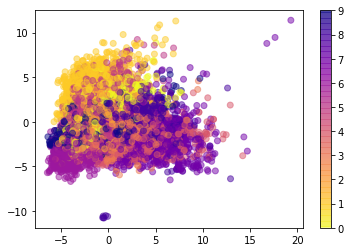

In [ ]:
plt.scatter(transformed2d[0], transformed2d[1], c=y_train, cmap='plasma_r', alpha=.5)
plt.colorbar()
plt.show()

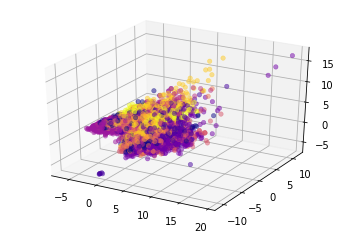

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter(transformed3d[0], transformed3d[1], transformed3d[2], c=y_train, cmap='plasma_r', alpha=.5, linewidth=0.5)
plt.show()